# **Import libraries**

In [1]:
!pip install -q zipfile36 contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
import contractions
import kagglehub

In [3]:
# Download and load NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Load spaCy English model
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
# Set styles
sns.set_style("whitegrid")
sns.set_context("talk")

# **Importing datasets**

## mental_health

In [6]:
path = kagglehub.dataset_download("szegeelim/mental-health")
mental_health = pd.read_csv(path + "/Combined Data.csv", index_col=0)

100%|██████████| 11.1M/11.1M [00:00<00:00, 55.4MB/s]

Extracting files...


## suicidal_tweet_detection_dataset

In [7]:
path = kagglehub.dataset_download("aunanya875/suicidal-tweet-detection-dataset")
suicidal_tweet_detection_dataset = pd.read_csv(path + "/Suicide_Ideation_Dataset(Twitter-based).csv")

100%|██████████| 88.3k/88.3k [00:00<00:00, 10.1MB/s]

Extracting files...


## reddit_mental_health_data

In [8]:
# Import dataset
path = kagglehub.dataset_download("neelghoshal/reddit-mental-health-data")
reddit_mental_health_data = pd.read_csv(path + "/data_to_be_cleansed.csv", index_col=0)

# Decode target variable
mental_health_target_map = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}

reddit_mental_health_data["target"] = reddit_mental_health_data["target"].map(mental_health_target_map)

100%|██████████| 1.83M/1.83M [00:00<00:00, 69.2MB/s]

Extracting files...


## dreaddit

In [9]:
!curl -o ./dreaddit.zip "http://www.cs.columbia.edu/~eturcan/data/dreaddit.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1317k  100 1317k    0     0  1482k      0 --:--:-- --:--:-- --:--:-- 1483k


In [10]:
# Concat CSV
with zipfile.ZipFile("dreaddit.zip") as z:

   with z.open("dreaddit-train.csv") as f:
      dreaddit_train = pd.read_csv(f)

   with z.open("dreaddit-test.csv") as f:
      dreaddit_test = pd.read_csv(f)

# Select training dataset
dreaddit = dreaddit_train

# Decode target variable
dreaddit['label'] = dreaddit['label'].map({0: 'Not stressful', 1: 'Stressful'})

# **Descriptive analysis - Raw**

## mental_health

In [11]:
mental_health.shape

(53043, 2)

In [12]:
mental_health.dtypes

,0
statement,object
status,object


In [13]:
mental_health.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [14]:
mental_health["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

## suicidal_tweet_detection_dataset

In [15]:
suicidal_tweet_detection_dataset.shape

(1787, 2)

In [16]:
suicidal_tweet_detection_dataset.dtypes

,0
Tweet,object
Suicide,object


In [17]:
suicidal_tweet_detection_dataset.describe()

,Tweet,Suicide
count,1785,1787
unique,1777,2
top,RT @palestinianho: patient: i hate myself and ...,Not Suicide post
freq,2,1127


## reddit_mental_health_data

In [18]:
reddit_mental_health_data.shape

(5957, 3)

In [19]:
reddit_mental_health_data.dtypes

,0
text,object
title,object
target,object


In [20]:
reddit_mental_health_data.describe()

,text,title,target
count,5607,5957,5957
unique,4420,4651,5
top,I am a research student doing research on Situ...,Survey on Situational Stress and Music (18 and...,Depression
freq,10,10,1202


In [72]:
reddit_mental_health_data["target"].unique()

array(['Depression', 'Stress', 'Bipolar disorder', 'Personality disorder',
       'Anxiety'], dtype=object)

## Dreaddit

In [21]:
dreaddit.shape

(2838, 116)

In [22]:
dreaddit.dtypes

,0
subreddit,object
post_id,object
sentence_range,object
text,object
id,int64
...,...
lex_dal_avg_pleasantness,float64
social_upvote_ratio,float64
social_num_comments,int64
syntax_fk_grade,float64


In [23]:
dreaddit.describe()

,id,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,13751.999295,0.808972,1.518107e+09,18.262156,4.684272,85.996124,35.240941,40.948231,67.044249,33.428157,...,1.088001,1.120099,1.000211,1.722759,1.536400,1.879385,0.843517,9.948555,5.448836,0.040740
std,17340.161897,0.177038,1.552209e+07,79.419166,3.316435,32.334887,26.486189,31.587117,32.880644,35.334770,...,0.117159,0.085227,0.006500,0.047835,0.102971,0.058932,0.174794,21.798032,2.535829,0.195490
min,4.000000,0.428571,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.485400,1.200000,1.561150,0.140000,0.000000,-1.918000,-1.000000
25%,926.250000,0.600000,1.509698e+09,2.000000,2.464243,65.000000,12.410000,12.135000,41.070000,1.420000,...,1.000000,1.000000,1.000000,1.691430,1.469745,1.841782,0.750000,2.000000,3.729973,-0.072222
50%,1891.500000,0.800000,1.517066e+09,5.000000,4.321886,81.000000,29.420000,33.520000,80.710000,25.770000,...,1.000000,1.142900,1.000000,1.721430,1.530295,1.878250,0.890000,5.000000,5.210000,0.044821
75%,25473.750000,1.000000,1.530898e+09,10.000000,6.505657,101.000000,55.057500,69.320000,96.180000,61.550000,...,1.142900,1.142900,1.000000,1.751760,1.596030,1.916243,1.000000,10.000000,6.855217,0.166667
max,55757.000000,1.000000,1.542592e+09,1435.000000,24.074231,310.000000,99.000000,99.000000,99.000000,99.000000,...,1.900000,1.500000,1.200000,2.007400,2.066670,2.158490,1.000000,416.000000,21.198919,1.000000


In [24]:
dreaddit.describe(include='object')

,subreddit,post_id,sentence_range,text,label
count,2838,2838,2838,2838,2838
unique,10,2343,173,2820,2
top,ptsd,7o5n2d,"(0, 5)",#NAME?,Stressful
freq,584,6,337,4,1488


In [73]:
dreaddit["label"].unique()

array(['Stressful', 'Not stressful'], dtype=object)

# **Data quality - Raw**

## mental_health

In [25]:
mental_health.isna().sum()

,0
statement,362
status,0


In [26]:
mental_health[mental_health['statement'].isna()]['status'].value_counts()

,count
status,
Personality disorder,124
Bipolar,100
Stress,82
Anxiety,47
Normal,8
Suicidal,1


## suicidal_tweet_detection_dataset

In [27]:
suicidal_tweet_detection_dataset.isna().sum()

,0
Tweet,2
Suicide,0


## reddit_mental_health_data

In [28]:
mental_health.isna().sum()

,0
statement,362
status,0


 ## Dreaddit

In [29]:
dreaddit_na = dreaddit.isna().sum()

dreaddit_na.loc[dreaddit_na > 0]

,0


# **Preprocessing**

## mental_health

In [30]:
# Delete rows with missing statement
mental_health = mental_health.dropna()

# Drop statement's dupicates
mental_health = mental_health.drop_duplicates(subset='statement')

## suicidal_tweet_detection_dataset

In [31]:
# Delete rows with missing Tweet
suicidal_tweet_detection_dataset = suicidal_tweet_detection_dataset.dropna()

# Drop tweet's dupicates
suicidal_tweet_detection_dataset = suicidal_tweet_detection_dataset.drop_duplicates(subset='Tweet')

## reddit_mental_health_data

In [32]:
# Delete rows with missing Tweet
reddit_mental_health_data = reddit_mental_health_data.dropna()

# Drop tweet's dupicates
reddit_mental_health_data = reddit_mental_health_data.drop_duplicates(subset='text')

## dreaddit

In [33]:
# Drop rows where text in missing
dreaddit = dreaddit.loc[dreaddit['text'] != '#NAME?']

# Drop dupicates
dreaddit = dreaddit.drop_duplicates(subset=['subreddit', 'text'])

In [ ]:
# Add column with name of the social where the text was posted
dreaddit['social'] = 'Reddit'

# **Descriptive analysis - Preprocessed**

## mental_health

In [34]:
mental_health.describe()

,statement,status
count,51073,51073
unique,51073,7
top,Getting through the day How do you get anythi...,Normal
freq,1,16039


## suicidal_tweet_deterction_dataset

In [35]:
mental_health.describe()

,statement,status
count,51073,51073
unique,51073,7
top,Getting through the day How do you get anythi...,Normal
freq,1,16039


## reddit_mental_health_data

In [36]:
reddit_mental_health_data.describe()

,text,title,target,social
count,4420,4420,4420,4420
unique,4420,4366,5,1
top,How do you get anything done with anxiety. I ...,Help,Depression,Reddit
freq,1,5,974,4420


## Dreaddit

In [37]:
dreaddit.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label',
       'confidence', 'social_timestamp', 'social_karma', 'syntax_ari',
       ...
       'lex_dal_min_activation', 'lex_dal_min_imagery',
       'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment', 'social'],
      dtype='object', length=117)

In [38]:
dreaddit.describe()

,id,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2828.000000,2828.000000,2.828000e+03,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,...,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000
mean,13702.026521,0.808648,1.518095e+09,18.296322,4.667403,86.004243,35.156400,40.804353,67.177995,33.305435,...,1.087822,1.119974,1.000212,1.722774,1.536308,1.879357,0.843200,9.966761,5.439535,0.040788
std,17325.086350,0.177075,1.552928e+07,79.555899,3.296242,32.304989,26.428581,31.504195,32.821996,35.272416,...,0.117131,0.084885,0.006512,0.047809,0.102863,0.058937,0.174916,21.832764,2.524228,0.195478
min,4.000000,0.428571,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.485400,1.200000,1.561150,0.140000,0.000000,-1.918000,-1.000000
25%,925.750000,0.600000,1.509673e+09,2.000000,2.459959,65.000000,12.410000,12.100000,41.670000,1.420000,...,1.000000,1.000000,1.000000,1.691450,1.469700,1.841778,0.750000,2.000000,3.727817,-0.072309
50%,1884.500000,0.800000,1.517055e+09,5.000000,4.301723,81.000000,29.330000,33.430000,80.870000,25.770000,...,1.000000,1.142900,1.000000,1.721525,1.530430,1.878250,0.890000,5.000000,5.209918,0.044821
75%,25406.500000,1.000000,1.530900e+09,10.000000,6.483585,101.000000,54.960000,69.140000,96.210000,60.962500,...,1.142900,1.142900,1.000000,1.751720,1.596067,1.916220,1.000000,10.000000,6.837835,0.166667
max,55757.000000,1.000000,1.542592e+09,1435.000000,24.074231,310.000000,99.000000,99.000000,99.000000,99.000000,...,1.900000,1.500000,1.200000,2.007400,2.066670,2.158490,1.000000,416.000000,21.198919,1.000000


In [39]:
dreaddit.describe(include='object')

,subreddit,post_id,sentence_range,text,label,social
count,2828,2828,2828,2828,2828,2828
unique,10,2336,173,2819,2,1
top,ptsd,7o5n2d,"(0, 5)",If you were raped on a daily basis from infanc...,Stressful,Reddit
freq,582,6,334,2,1486,2828


# **Data quality - Preprocessed**

## mental_health

In [40]:
mental_health.isna().sum()

,0
statement,0
status,0


In [41]:
mental_health['status'].value_counts()

,count
status,
Normal,16039
Depression,15087
Suicidal,10641
Anxiety,3617
Bipolar,2501
Stress,2293
Personality disorder,895


## suicidal_tweet_detection_dataset

In [42]:
suicidal_tweet_detection_dataset.isna().sum()

,0
Tweet,0
Suicide,0
social,0


In [43]:
suicidal_tweet_detection_dataset['Suicide'].value_counts()

,count
Suicide,
Not Suicide post,1124
Potential Suicide post,653


## reddit_mental_health_data

In [44]:
reddit_mental_health_data.isna().sum()

,0
text,0
title,0
target,0
social,0


In [45]:
reddit_mental_health_data['target'].value_counts()

,count
target,
Depression,974
Anxiety,933
Personality disorder,895
Bipolar disorder,809
Stress,809


# **Feature engineering**

## mental_health

In [46]:
# Add text length feature (word count)
mental_health['text_length'] = mental_health['statement'].apply(lambda x: len(str(x).split()))

In [47]:
# Clean statements
def preprocess(text):
    """Lowercase, remove non-alpha chars, strip stopwords."""
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        words = text.strip().split()
        meaningful_words = [word for word in words if word not in nltk_stopwords]
        return ' '.join(meaningful_words)
    return ""

mental_health['clean_statement'] = mental_health['statement'].apply(preprocess)

## suicidal_tweet_detection_dataset

In [48]:
# Calculate text length
suicidal_tweet_detection_dataset['text_length'] = suicidal_tweet_detection_dataset['Tweet'].apply(lambda x: len(str(x).split()))

In [ ]:
# Add column with name of the social where the text was posted
suicidal_tweet_detection_dataset['social'] = 'Twitter'

## reddit_mental_health_data

In [49]:
# Calculate text length
reddit_mental_health_data['text_length'] = reddit_mental_health_data['text'].apply(lambda x: len(str(x).split()))

In [ ]:
# Add column with name of the social where the text was posted
reddit_mental_health_data['social'] = 'Reddit'

## dreaddit

In [50]:
# Add text length feature (word count)
dreaddit['text_length'] = dreaddit['text'].apply(lambda x: len(str(x).split()))

In [51]:
# Map categorical stress label to numeric
dreaddit['label_num'] = dreaddit['label'].map({'Not stressful': 0, 'Stressful': 1})

# **Data visualization**

## mental_health

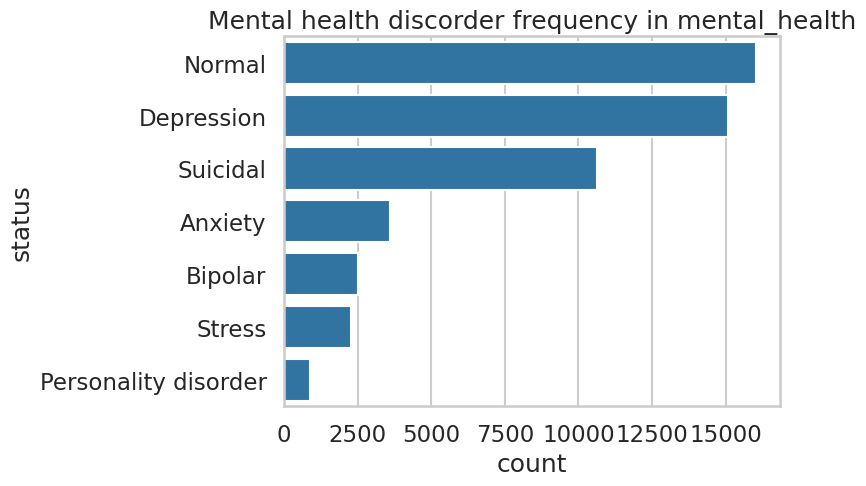

In [52]:
# Plot a frequency plot of the status associated to the tweet
sns.countplot(data=mental_health,
              y='status',
              order=mental_health['status'].value_counts().index)

plt.title("Mental health discorder frequency in mental_health")

plt.show()

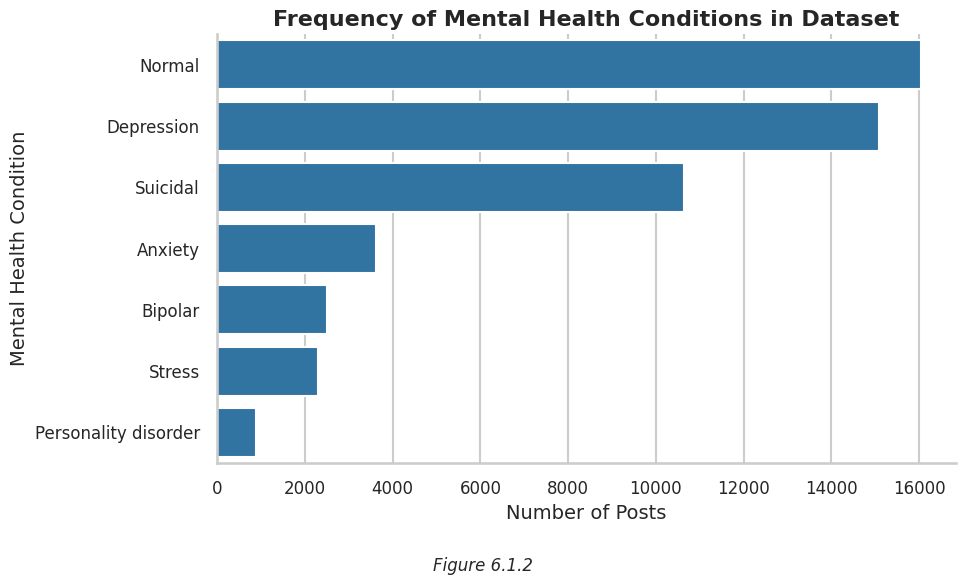

In [53]:
# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(10, 6))

# Define the unique number of statuses
unique_statuses = mental_health['status'].nunique()

# Plot the distribution of mental health conditions by post count
sns.countplot(
    data=mental_health,
    y='status',
    order=mental_health['status'].value_counts().index,
    legend=False,
    ax=ax
)

# Add a descriptive title and axis labels for clarity
ax.set_title("Frequency of Mental Health Conditions in Dataset", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Posts", fontsize=14)
ax.set_ylabel("Mental Health Condition", fontsize=14)

# Adjust tick label sizes to improve readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove top and right spines for a cleaner look
sns.despine(ax=ax)

# Adjust layout and make space at the bottom for the caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure number and caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.1.2',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

plt.show()

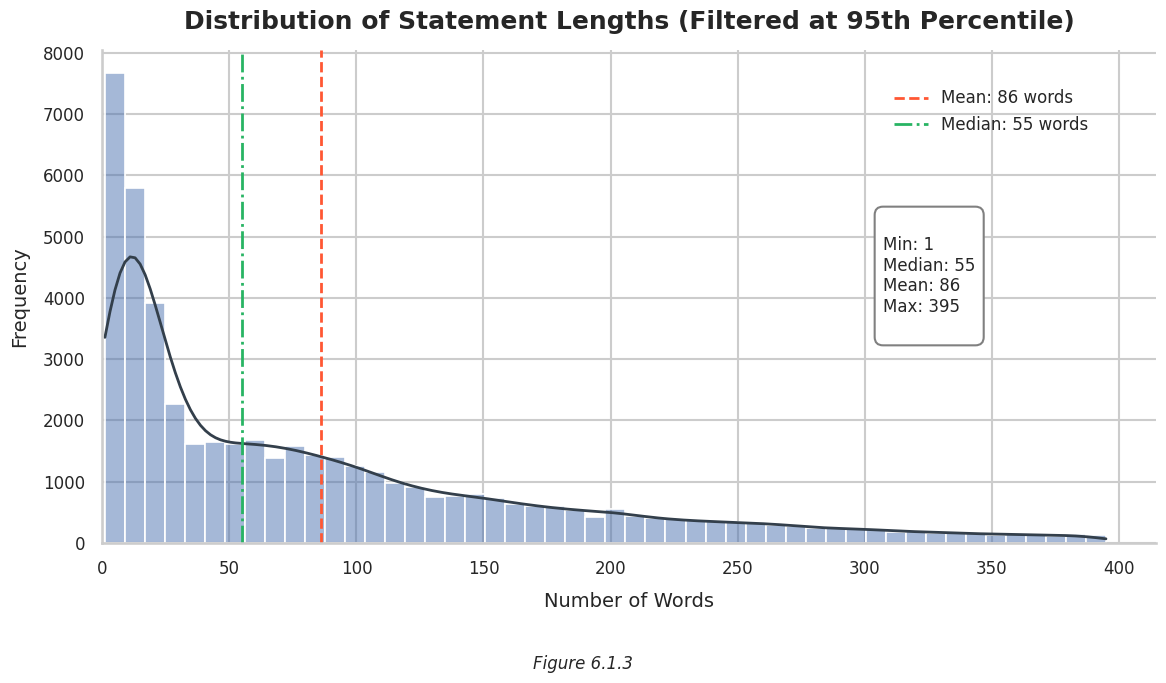

In [54]:
# Calculate 95th percentile threshold
percentile_95 = mental_health['text_length'].quantile(0.95)

# Filter data below the 95th percentile
filtered_data = mental_health[mental_health['text_length'] <= percentile_95]

# Calculate summary stats on filtered data
mean_length = filtered_data['text_length'].mean()
median_length = filtered_data['text_length'].median()
max_length = filtered_data['text_length'].max()
min_length = filtered_data['text_length'].min()

# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(12, 7))

# Plot histogram on filtered data
sns.histplot(
    data=filtered_data,
    x='text_length',
    bins=50,
    kde=True,
    color='#4C72B0',
    edgecolor='white',
    ax=ax
)

# Style the KDE line
plt.setp(ax.lines, linewidth=2, color='#333F4B')

# Add mean and median vertical lines
ax.axvline(mean_length, color='#FF5733', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.0f} words')
ax.axvline(median_length, color='#28B463', linestyle='-.', linewidth=2, label=f'Median: {median_length:.0f} words')

# Add title and labels
ax.set_title('Distribution of Statement Lengths (Filtered at 95th Percentile)', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Number of Words', fontsize=14, labelpad=10)
ax.set_ylabel('Frequency', fontsize=14, labelpad=10)

# Legend configuration
ax.legend(frameon=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.95, 0.95))

# Tick label size adjustments
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove top and right spines for a cleaner look
sns.despine(ax=ax)

# Add summary stats box inside the figure
fig.text(
    0.75, 0.5,
    f'''
Min: {min_length:.0f}
Median: {median_length:.0f}
Mean: {mean_length:.0f}
Max: {max_length:.0f}
''',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
)

# Adjust layout to leave space for the figure caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.1.3',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

# Set x axis lower limit
plt.xlim(0)

# Show the plot
plt.show()

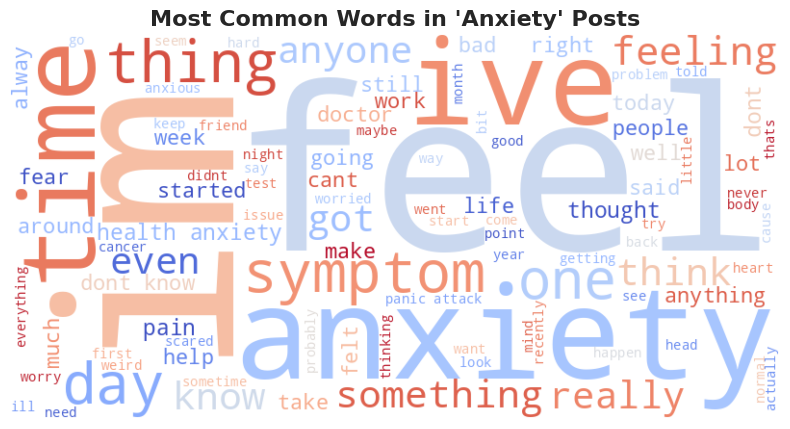

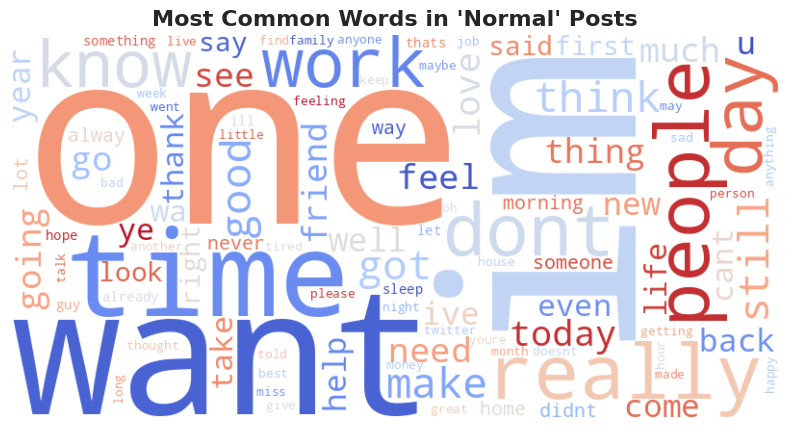

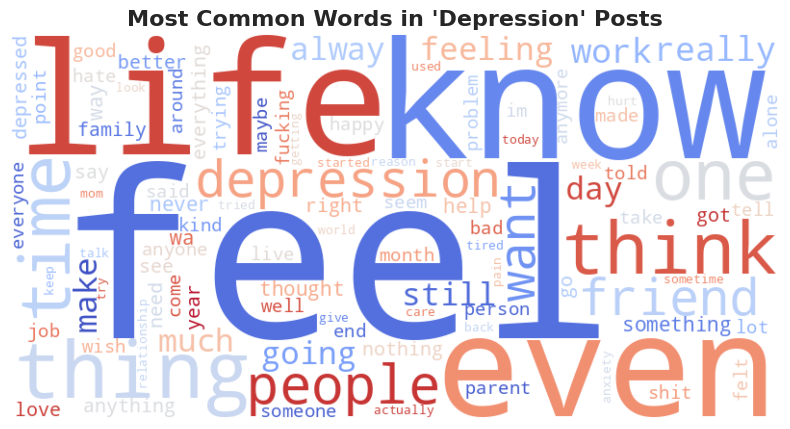

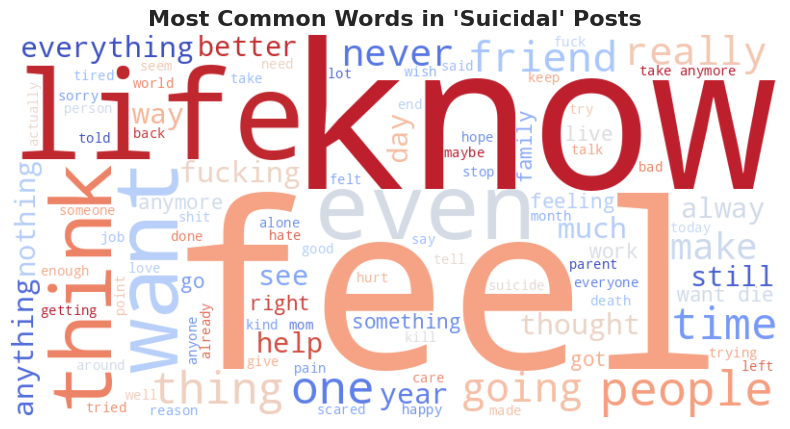

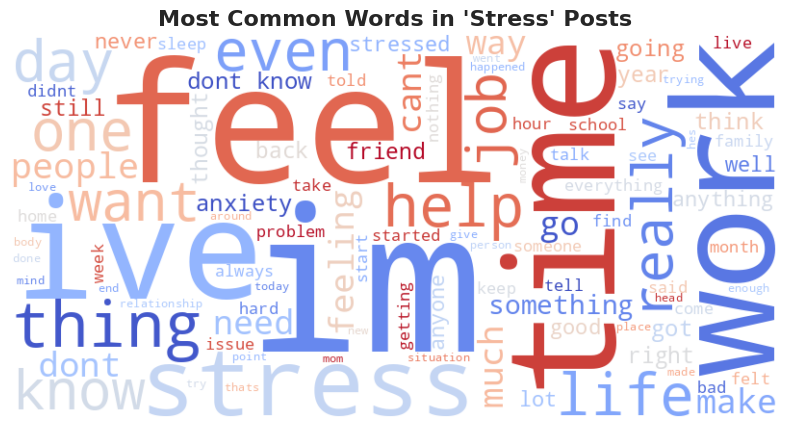

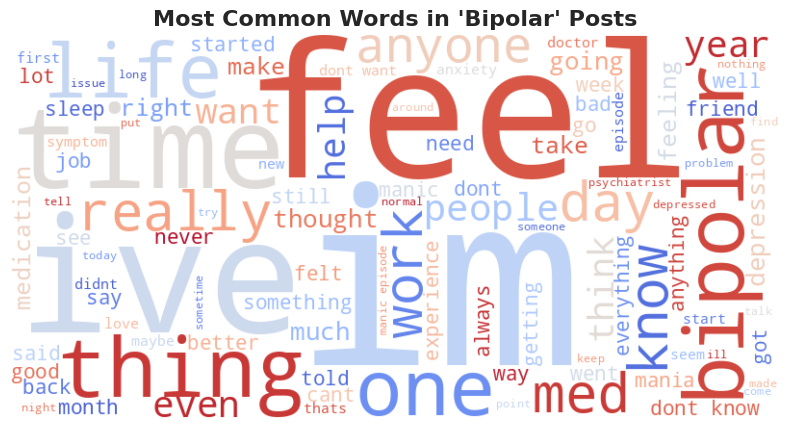

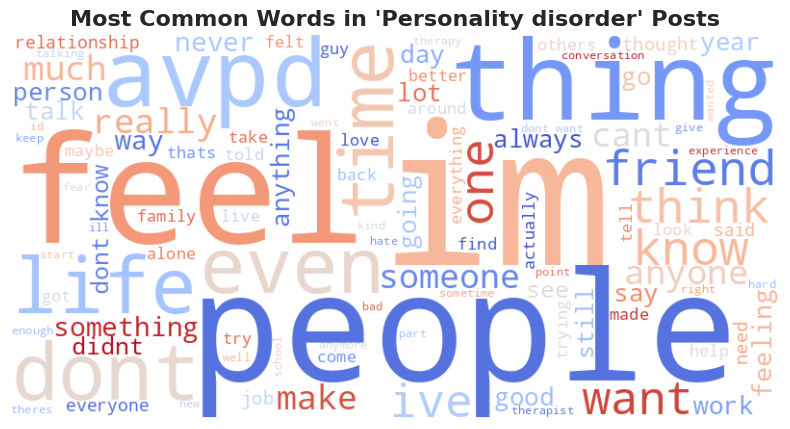

In [55]:
# Define a function to generate and display word clouds
def generate_wordcloud(text, title, colormap='viridis'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

# Loop through each unique status and generate a word cloud
for status in mental_health['status'].unique():
    # Join all clean statements for this condition
    text = ' '.join(mental_health[mental_health['status'] == status]['clean_statement'])

    # Generate the word cloud
    generate_wordcloud(text, f"Most Common Words in '{status}' Posts", colormap='coolwarm')


## suicidal_tweet_detection_dataset

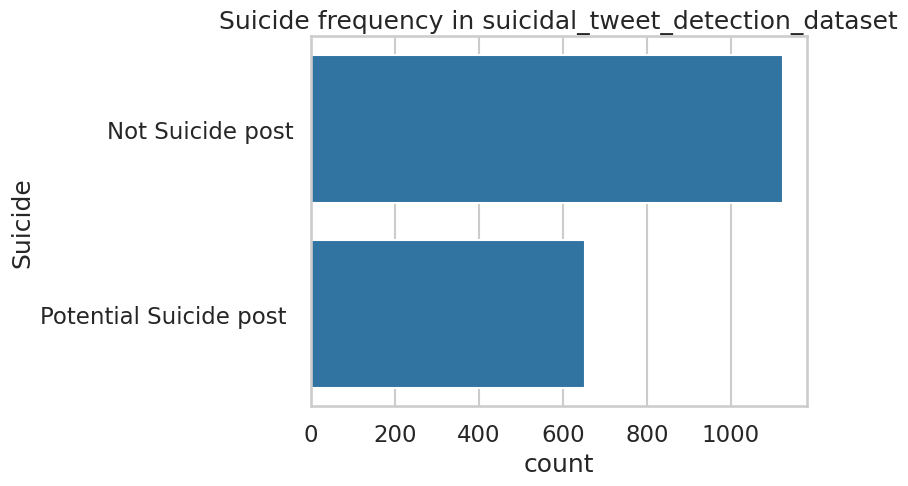

In [56]:
# Plot a frequency plot of the status associated to the tweet
sns.countplot(data=suicidal_tweet_detection_dataset,
              y='Suicide',
              order=suicidal_tweet_detection_dataset['Suicide'].value_counts().index
            )
# Set title
plt.title("Suicide frequency in suicidal_tweet_detection_dataset")

plt.show()

In [57]:
# Get counts of each class
suicide_counts = suicidal_tweet_detection_dataset['Suicide'].value_counts()

# Convert to a DataFrame for better readability
suicide_counts_df = suicide_counts.reset_index()
suicide_counts_df.columns = ['Suicide Status', 'Count']

print(suicide_counts_df)

            Suicide Status  Count
0         Not Suicide post   1124
1  Potential Suicide post     653


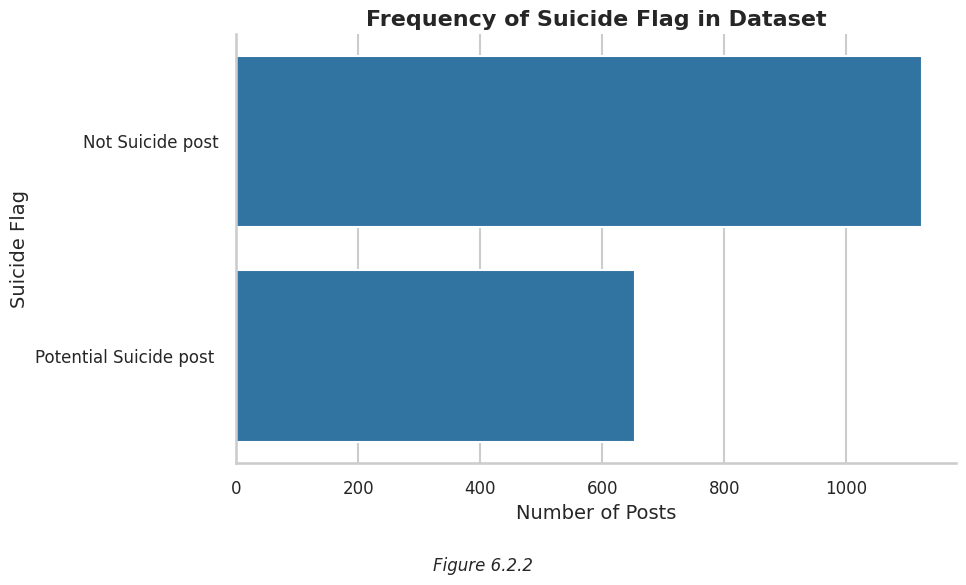

In [58]:
# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(10, 6))

# Define the unique number of statuses
unique_statuses = suicidal_tweet_detection_dataset['Suicide'].nunique()

# Plot the distribution of mental health conditions by post count
sns.countplot(
    data=suicidal_tweet_detection_dataset,
    y='Suicide',
    order=suicidal_tweet_detection_dataset['Suicide'].value_counts().index,
    legend=False,
    ax=ax  # Pass the axis to sns.countplot
)

# Add a descriptive title and axis labels for clarity
ax.set_title("Frequency of Suicide Flag in Dataset", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Posts", fontsize=14)
ax.set_ylabel("Suicide Flag", fontsize=14)

# Adjust tick label sizes to improve readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove top and right spines for a cleaner look
sns.despine(ax=ax)

# Adjust layout and make space at the bottom for the caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure number and caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.2.2',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

plt.show()

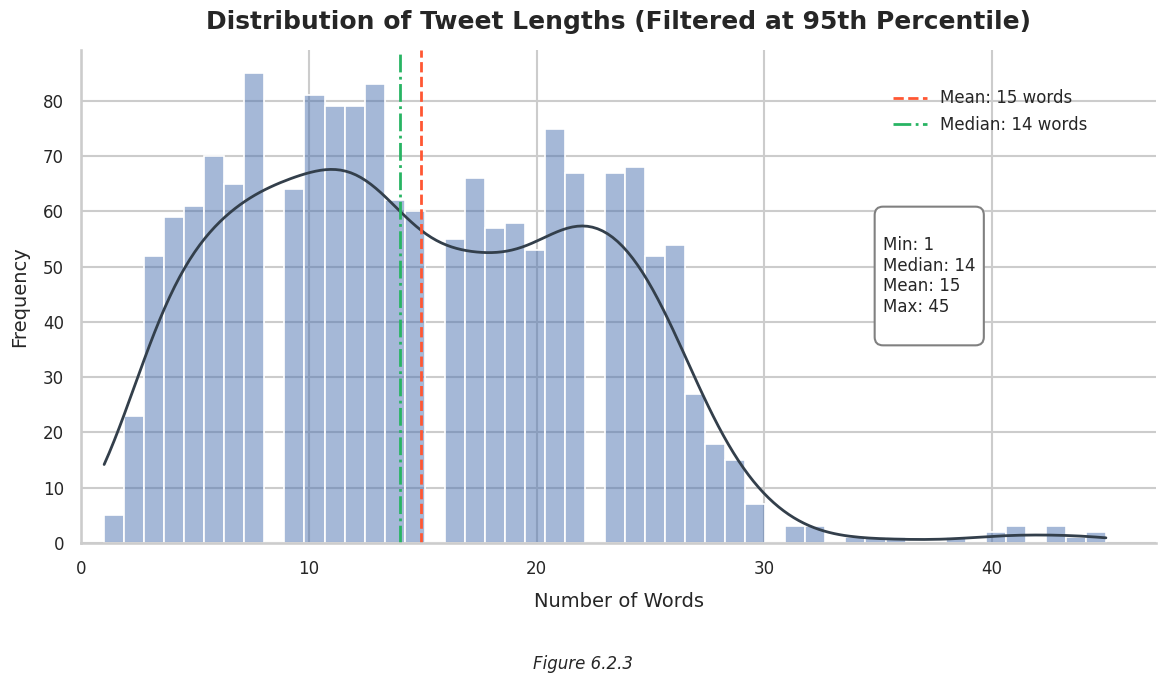

In [59]:
# Calculate 95th percentile threshold
percentile_95 = suicidal_tweet_detection_dataset['text_length'].quantile(0.95)

# Filter data below the 95th percentile to reduce skew from outliers
filtered_data = suicidal_tweet_detection_dataset[suicidal_tweet_detection_dataset['text_length'] <= percentile_95]

# Calculate summary statistics on filtered data
mean_length = filtered_data['text_length'].mean()
median_length = filtered_data['text_length'].median()
max_length = filtered_data['text_length'].max()
min_length = filtered_data['text_length'].min()

# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(12, 7))

# Plot histogram on filtered data
sns.histplot(
    data=filtered_data,
    x='text_length',
    bins=50,
    kde=True,
    color='#4C72B0',
    edgecolor='white',
    ax=ax
)

# Style the KDE line for better visibility
plt.setp(ax.lines, linewidth=2, color='#333F4B')

# Add mean and median vertical lines
ax.axvline(mean_length, color='#FF5733', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.0f} words')
ax.axvline(median_length, color='#28B463', linestyle='-.', linewidth=2, label=f'Median: {median_length:.0f} words')

# Add title and axis labels
ax.set_title('Distribution of Tweet Lengths (Filtered at 95th Percentile)', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Number of Words', fontsize=14, labelpad=10)
ax.set_ylabel('Frequency', fontsize=14, labelpad=10)

# Configure legend
ax.legend(frameon=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.95, 0.95))

# Adjust tick label sizes for readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove spines for a cleaner appearance
sns.despine(ax=ax)

# Add summary stats box inside the figure
fig.text(
    0.75, 0.5,
    f'''
Min: {min_length:.0f}
Median: {median_length:.0f}
Mean: {mean_length:.0f}
Max: {max_length:.0f}
''',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
)

# Adjust layout and leave space at the bottom for a caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.2.3',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

plt.xlim(0)
plt.show()

Top Bigrams in Suicidal Tweets:
[('i am', 259), ('want to', 197), ('do not', 151), ('i do', 124), ('i have', 112), ('and i', 100), ('to be', 99), ('tired of', 92), ('i want', 84), ('i just', 81), ('i hate', 77), ('can not', 72), ('my life', 67), ('to die', 67), ('not want', 64), ('i can', 59), ('hate myself', 52), ('going to', 45), ('kill myself', 45), ('but i', 45)]

Top Bigrams in Non-Suicidal Tweets:
[('i am', 116), ('it is', 68), ('want to', 43), ('going to', 41), ('you are', 40), ('i have', 37), ('do not', 36), ('in the', 33), ('i will', 32), ('to be', 32), ('i want', 31), ('that is', 30), ('for the', 29), ('to the', 29), ('have a', 28), ('i love', 28), ('can not', 25), ('of the', 23), ('i do', 20), ('is the', 20)]


<ipython-input-60-50196d77dc1a>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suicidal_bigram_freqs, y=suicidal_bigram_words, palette='Reds_r', ax=ax)


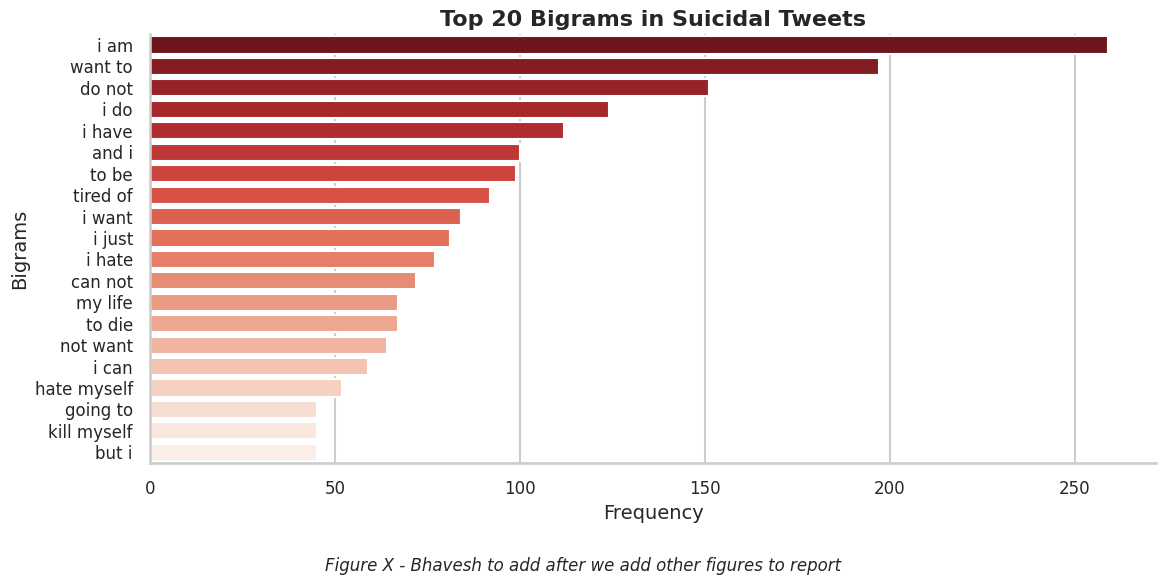

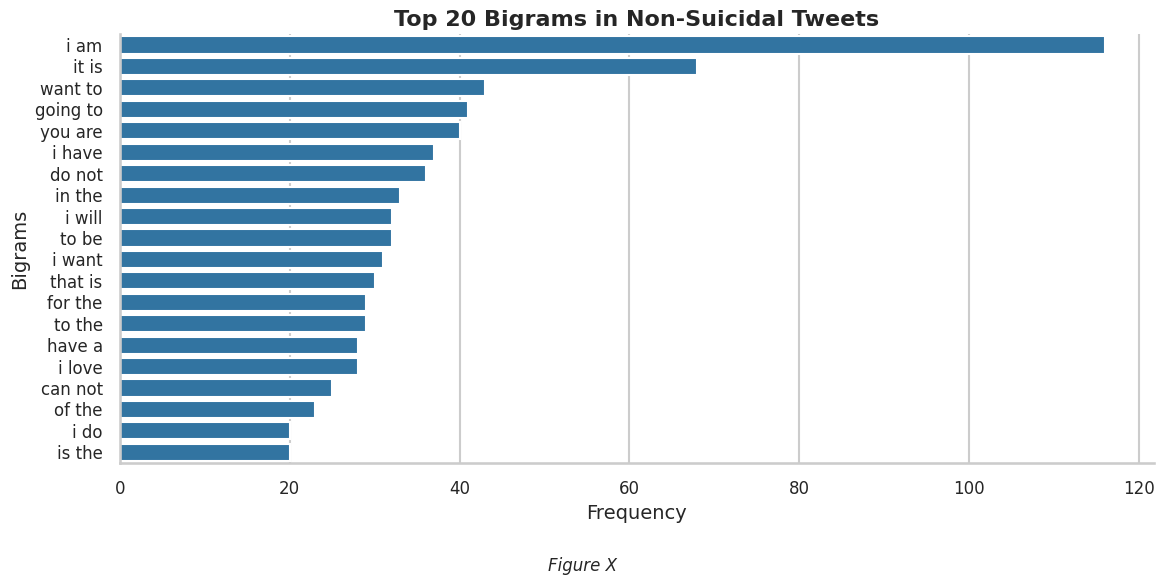

In [60]:

def clean_tokenize_spacy(text):
    """Expand contractions, lowercase, tokenize, and retain alphabetic tokens (including expanded ones)."""
    if isinstance(text, str):
        expanded_text = contractions.fix(text)
        doc = nlp(expanded_text.lower())
        tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
        return tokens
    return []

def get_top_ngrams(tweets, ngram_range=2, top_n=20):
    """Extract top n-grams from a list of tweets."""
    ngram_list = []

    for tweet in tweets:
        tokens = clean_tokenize_spacy(tweet)
        if len(tokens) >= ngram_range:
            ngrams = zip(*[tokens[i:] for i in range(ngram_range)])
            ngram_list.extend([' '.join(gram) for gram in ngrams])

    ngram_counts = Counter(ngram_list)
    return ngram_counts.most_common(top_n)

# Strip whitespace from 'Suicide' column values
suicidal_tweet_detection_dataset['Suicide'] = suicidal_tweet_detection_dataset['Suicide'].str.strip()

# Filter suicidal and non-suicidal tweets
suicidal_tweets = suicidal_tweet_detection_dataset[
    suicidal_tweet_detection_dataset['Suicide'] == 'Potential Suicide post'
]['Tweet']

non_suicidal_tweets = suicidal_tweet_detection_dataset[
    suicidal_tweet_detection_dataset['Suicide'] == 'Not Suicide post'
]['Tweet']

# Get top bigrams for each class
top_bigrams_suicidal = get_top_ngrams(suicidal_tweets, ngram_range=2, top_n=20)
top_bigrams_non_suicidal = get_top_ngrams(non_suicidal_tweets, ngram_range=2, top_n=20)

print("Top Bigrams in Suicidal Tweets:")
print(top_bigrams_suicidal)

print("\nTop Bigrams in Non-Suicidal Tweets:")
print(top_bigrams_non_suicidal)

# Plot suicidal tweet bigrams
if top_bigrams_suicidal:
    suicidal_bigram_words = [bigram for bigram, freq in top_bigrams_suicidal]
    suicidal_bigram_freqs = [freq for bigram, freq in top_bigrams_suicidal]

    fig, ax = plt.subplots(figsize=(12, 6))  # Use fig and ax for better control
    sns.barplot(x=suicidal_bigram_freqs, y=suicidal_bigram_words, palette='Reds_r', ax=ax)

    ax.set_title('Top 20 Bigrams in Suicidal Tweets', fontsize=16, fontweight='bold')
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('Bigrams', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    sns.despine(ax=ax)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    # Add figure caption below the plot
    fig.text(
        0.5, 0.02,
        'Figure X - Bhavesh to add after we add other figures to report',
        ha='center',
        fontsize=12,
        fontstyle='italic'
    )

    plt.show()
else:
    print("No bigrams found in suicidal tweets.")

# Plot non-suicidal tweet bigrams
if top_bigrams_non_suicidal:
    non_suicidal_bigram_words = [bigram for bigram, freq in top_bigrams_non_suicidal]
    non_suicidal_bigram_freqs = [freq for bigram, freq in top_bigrams_non_suicidal]

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=non_suicidal_bigram_freqs, y=non_suicidal_bigram_words, ax=ax)

    ax.set_title('Top 20 Bigrams in Non-Suicidal Tweets', fontsize=16, fontweight='bold')
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('Bigrams', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    sns.despine(ax=ax)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    # Add figure caption below the plot
    fig.text(
        0.5, 0.02,
        'Figure X',
        ha='center',
        fontsize=12,
        fontstyle='italic'
    )

    plt.show()
else:
    print("No bigrams found in non-suicidal tweets.")


## reddit_mental_health_data

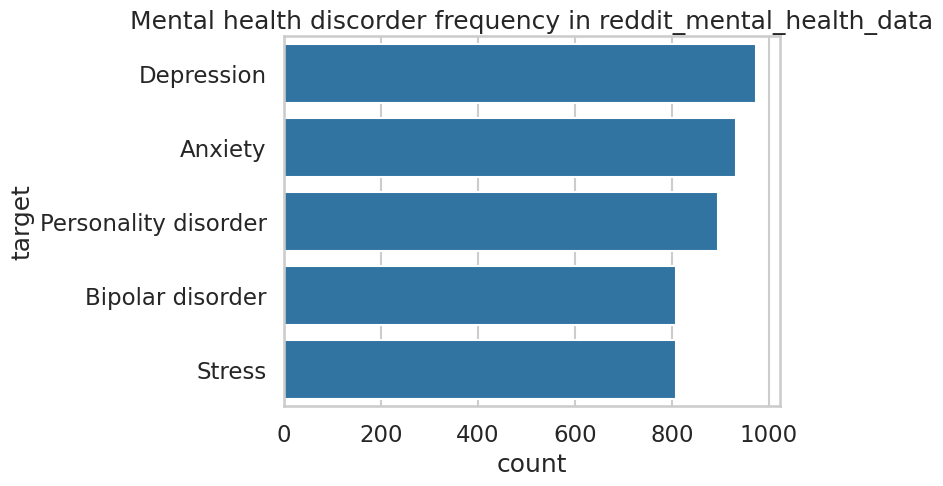

In [61]:
# Plot a frequency plot of the status associated to the tweet
sns.countplot(data=reddit_mental_health_data,
              y='target',
              order=reddit_mental_health_data['target'].value_counts().index
            )


plt.title("Mental health discorder frequency in reddit_mental_health_data")
plt.show()

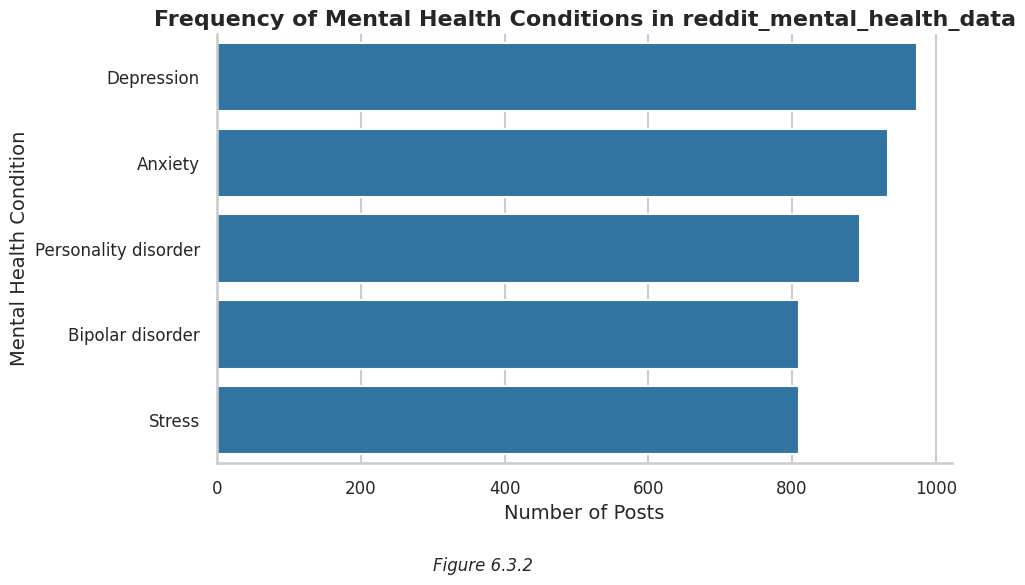

In [62]:
# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(10, 6))

# Define the unique number of targets (mental health conditions)
unique_targets = reddit_mental_health_data['target'].nunique()

# Plot the distribution of mental health conditions by post count
sns.countplot(
    data=reddit_mental_health_data,
    y='target',
    order=reddit_mental_health_data['target'].value_counts().index,
    ax=ax,
    legend=False
)

# Add a descriptive title and axis labels for clarity
ax.set_title("Frequency of Mental Health Conditions in reddit_mental_health_data", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Posts", fontsize=14)
ax.set_ylabel("Mental Health Condition", fontsize=14)

# Adjust tick label sizes to improve readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove top and right spines for a cleaner look
sns.despine(ax=ax)

# Adjust layout and make space at the bottom for the caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure number and caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.3.2',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

# Display the plot
plt.show()

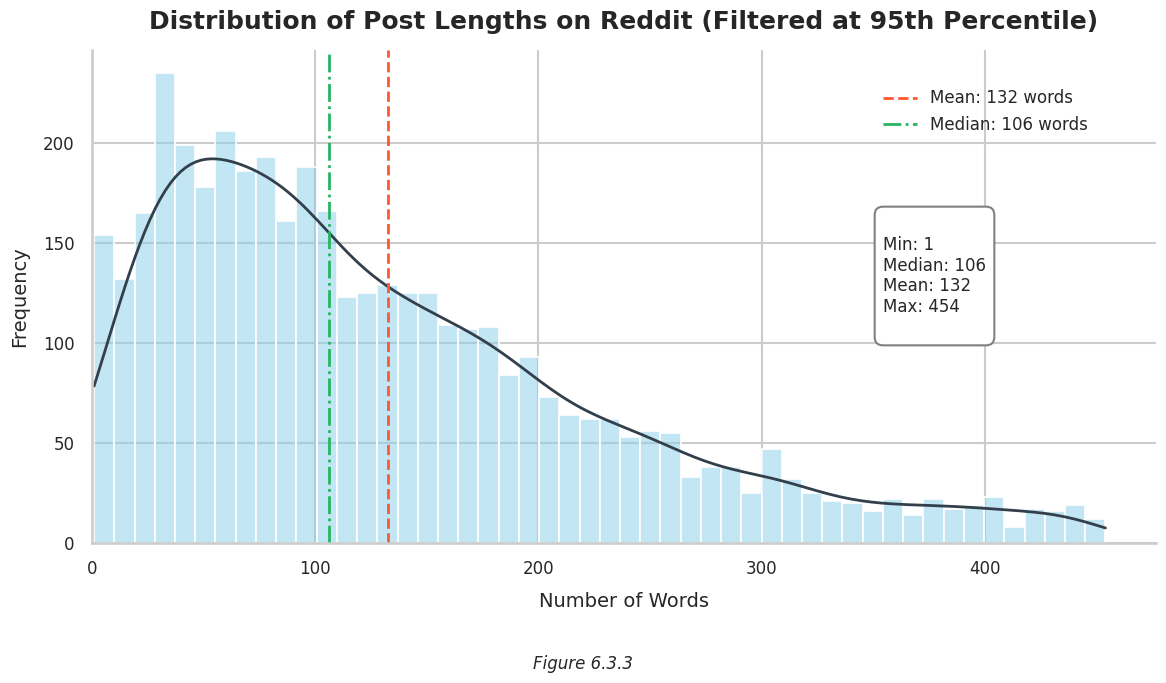

In [63]:
# Calculate 95th percentile threshold to reduce skew from long outliers
percentile_95 = reddit_mental_health_data['text_length'].quantile(0.95)

# Filter data below the 95th percentile
filtered_data = reddit_mental_health_data[reddit_mental_health_data['text_length'] <= percentile_95]

# Calculate summary statistics on filtered data
mean_length = filtered_data['text_length'].mean()
median_length = filtered_data['text_length'].median()
max_length = filtered_data['text_length'].max()
min_length = filtered_data['text_length'].min()

# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(12, 7))

# Plot histogram on filtered data
sns.histplot(
    data=filtered_data,
    x='text_length',
    bins=50,
    kde=True,
    color='skyblue',
    edgecolor='white',
    ax=ax
)

# Style the KDE line for better visibility
plt.setp(ax.lines, linewidth=2, color='#333F4B')

# Add mean and median vertical lines
ax.axvline(mean_length, color='#FF5733', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.0f} words')
ax.axvline(median_length, color='#28B463', linestyle='-.', linewidth=2, label=f'Median: {median_length:.0f} words')

# Add title and axis labels
ax.set_title('Distribution of Post Lengths on Reddit (Filtered at 95th Percentile)', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Number of Words', fontsize=14, labelpad=10)
ax.set_ylabel('Frequency', fontsize=14, labelpad=10)

# Configure legend
ax.legend(frameon=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.95, 0.95))

# Adjust tick label sizes for readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove spines for a cleaner appearance
sns.despine(ax=ax)

# Add summary stats box inside the figure
fig.text(
    0.75, 0.5,
    f'''
Min: {min_length:.0f}
Median: {median_length:.0f}
Mean: {mean_length:.0f}
Max: {max_length:.0f}
''',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
)

# Adjust layout and leave space at the bottom for a caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.3.3',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

plt.xlim(0)
plt.show()


Top Bigrams for Depression Posts (Filtered):

mental health: 49
year old: 44
high school: 41
long time: 39
depression anxiety: 37
good friend: 30
panic attack: 30
day day: 29
friend family: 27
thing well: 27


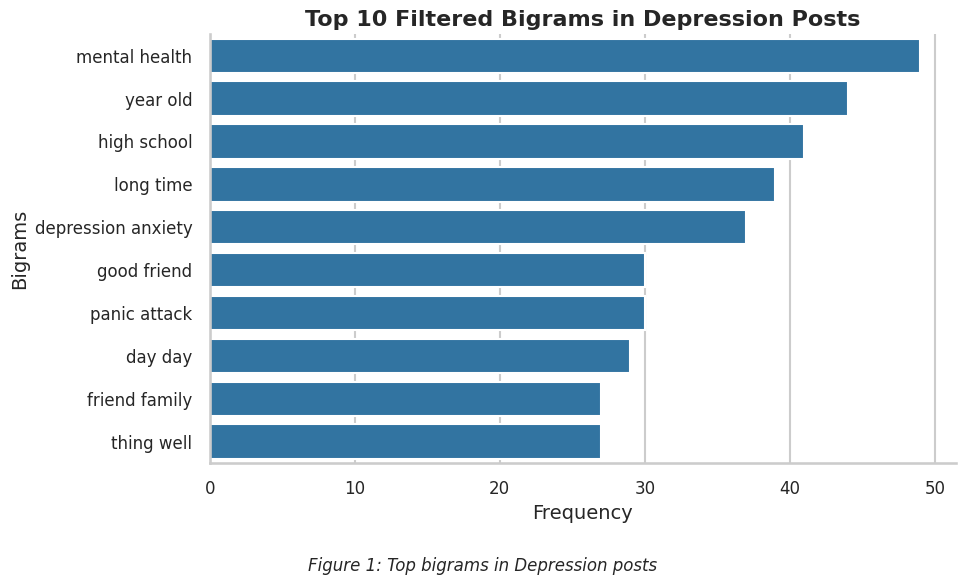


Top Bigrams for Stress Posts (Filtered):

stress anxiety: 52
year old: 43
mental health: 34
stress stress: 33
stress management: 31
panic attack: 29
way stress: 28
anxiety stress: 27
day day: 26
stress level: 25


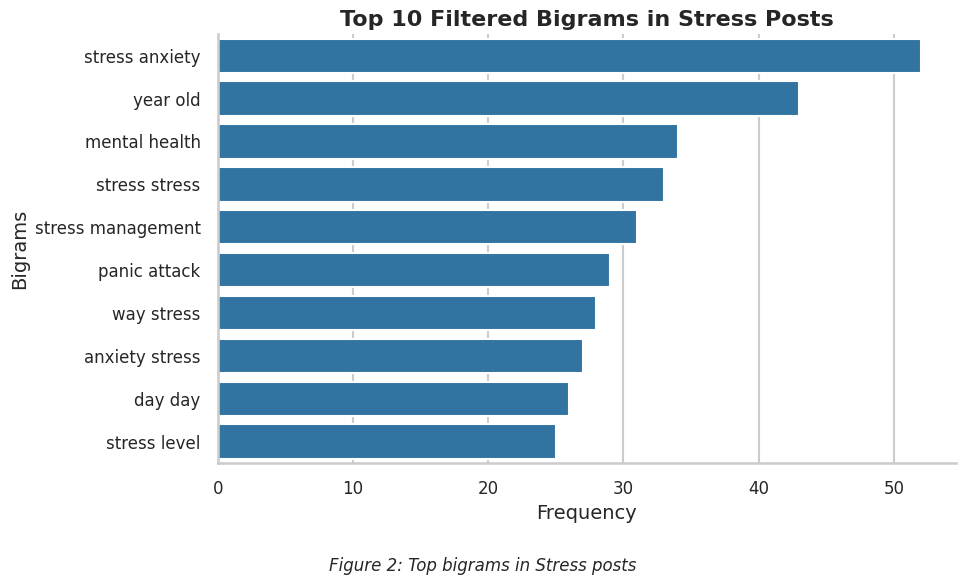


Top Bigrams for Bipolar disorder Posts (Filtered):

manic episode: 101
depressive episode: 69
mental health: 64
bipolar disorder: 59
year old: 36
mental illness: 33
mixed episode: 28
people bipolar: 25
hypomanic episode: 23
panic attack: 22


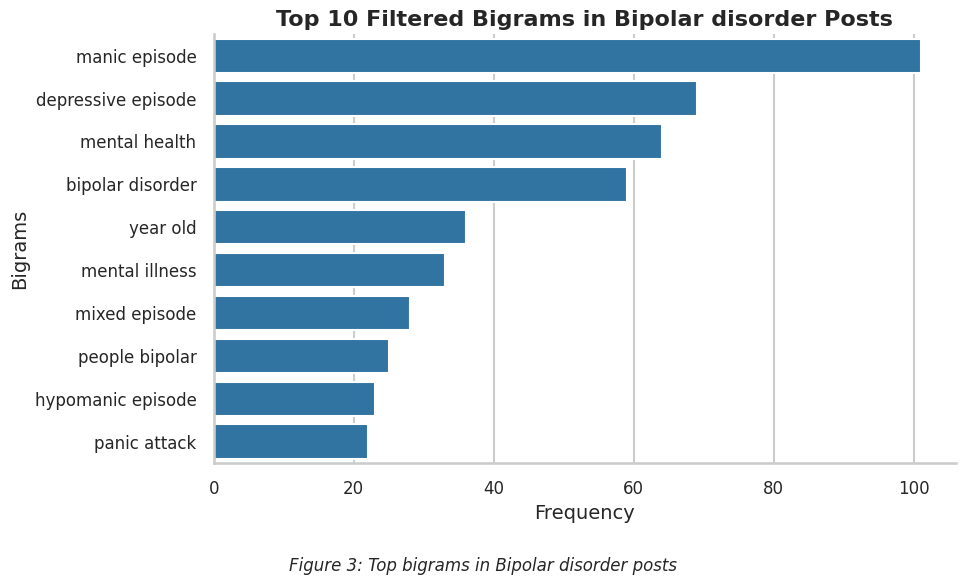


Top Bigrams for Personality disorder Posts (Filtered):

social anxiety: 71
mental health: 55
year old: 48
people people: 38
personality disorder: 34
social medium: 33
friend friend: 31
good friend: 30
social interaction: 30
high school: 27


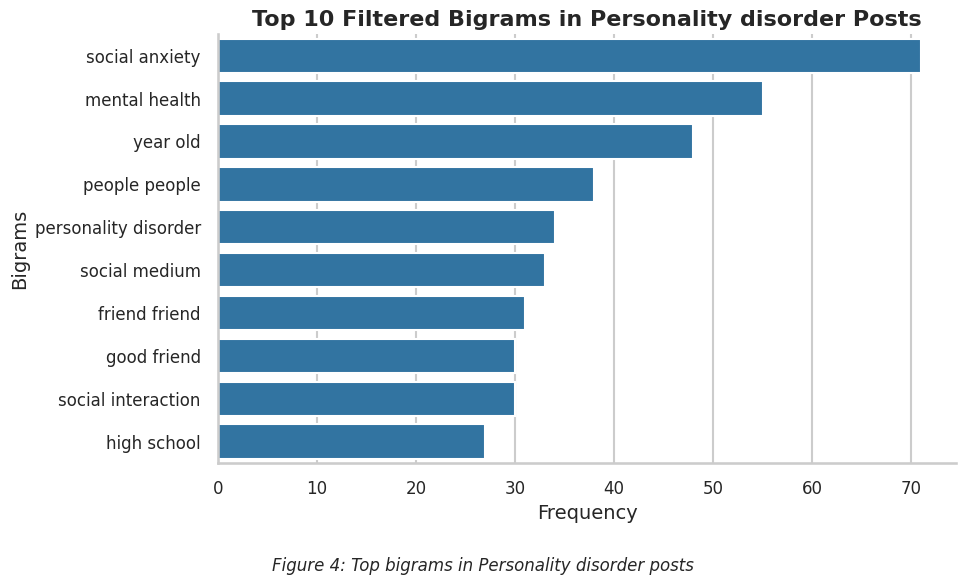


Top Bigrams for Anxiety Posts (Filtered):

panic attack: 180
health anxiety: 68
anxiety bad: 59
anxiety attack: 46
mental health: 42
bad anxiety: 42
heart rate: 42
anxiety depression: 39
physical symptom: 38
chest pain: 38


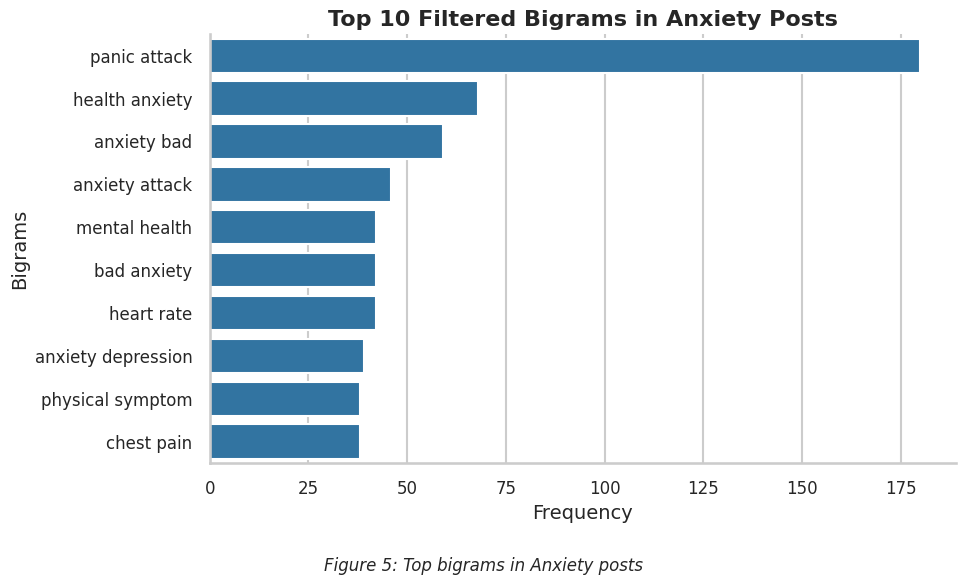

In [64]:
def clean_tokenize_filtered(text):
    """
    Tokenize text, lemmatize, remove stopwords,
    and keep only NOUN and ADJ tokens.
    """
    if isinstance(text, str):
        doc = nlp(text.lower())
        allowed_pos = ['NOUN', 'ADJ']
        tokens = [
            token.lemma_
            for token in doc
            if token.is_alpha and not token.is_stop and token.pos_ in allowed_pos
        ]
        return tokens
    return []

def get_top_ngrams(texts, ngram_range=2, top_n=20):
    """
    Extract top n-grams from a list of texts after filtering.
    """
    ngram_list = []

    for text in texts:
        tokens = clean_tokenize_filtered(text)
        if len(tokens) >= ngram_range:
            ngrams = zip(*[tokens[i:] for i in range(ngram_range)])
            ngram_list.extend([' '.join(gram) for gram in ngrams])

    ngram_counts = Counter(ngram_list)
    return ngram_counts.most_common(top_n)

# Iterate through each mental health condition in the dataset
unique_conditions = reddit_mental_health_data['target'].unique()

# Start figure numbering (optional)
figure_num = 1

for condition in unique_conditions:
    print(f"\nTop Bigrams for {condition} Posts (Filtered):\n")

    # Combine 'text' and 'title' fields for analysis
    condition_texts = (
        reddit_mental_health_data[reddit_mental_health_data['target'] == condition]['text'] + ' ' +
        reddit_mental_health_data[reddit_mental_health_data['target'] == condition]['title']
    )

    # Get top bigrams for the condition
    top_bigrams = get_top_ngrams(condition_texts, ngram_range=2, top_n=10)

    # Print bigrams and their frequencies
    for bigram, freq in top_bigrams:
        print(f"{bigram}: {freq}")

    # Plot top bigrams if any are found
    if top_bigrams:
        bigram_phrases = [bigram for bigram, freq in top_bigrams]
        bigram_freqs = [freq for bigram, freq in top_bigrams]

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Barplot for bigrams
        sns.barplot(x=bigram_freqs, y=bigram_phrases, ax=ax)

        # Titles and labels
        ax.set_title(f'Top 10 Filtered Bigrams in {condition} Posts', fontsize=16, fontweight='bold')
        ax.set_xlabel('Frequency', fontsize=14)
        ax.set_ylabel('Bigrams', fontsize=14)

        # Adjust tick label sizes
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        sns.despine(ax=ax)

        # Adjust layout and reserve space for caption
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)

        # Add figure caption below the plot
        fig.text(
            0.5, 0.02,  # Centered at the bottom
            f'Figure {figure_num}: Top bigrams in {condition} posts',
            ha='center',
            fontsize=12,
            fontstyle='italic'
        )

        plt.show()

        # Increment figure number for next plot
        figure_num += 1

    else:
        print(f"No meaningful bigrams found for {condition} posts.")

## dreaddit

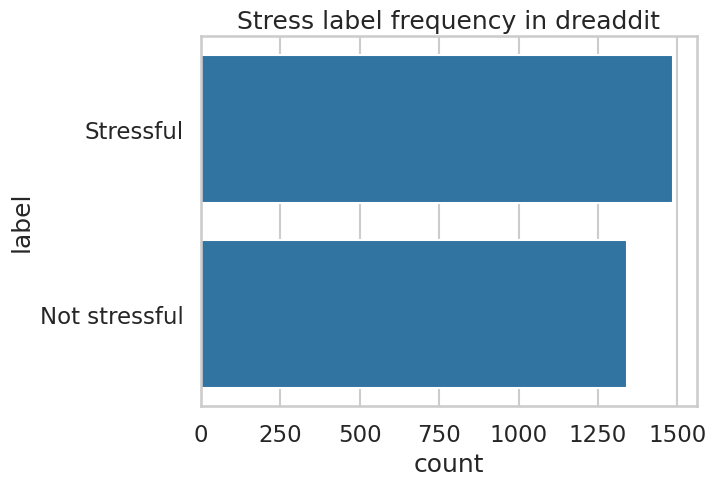

In [65]:
# Plot a frequency plot of the status associated to the tweet
sns.countplot(data=dreaddit,
              y='label',
              order=dreaddit['label'].value_counts().index
            )
# Set title
plt.title("Stress label frequency in dreaddit")

plt.show()

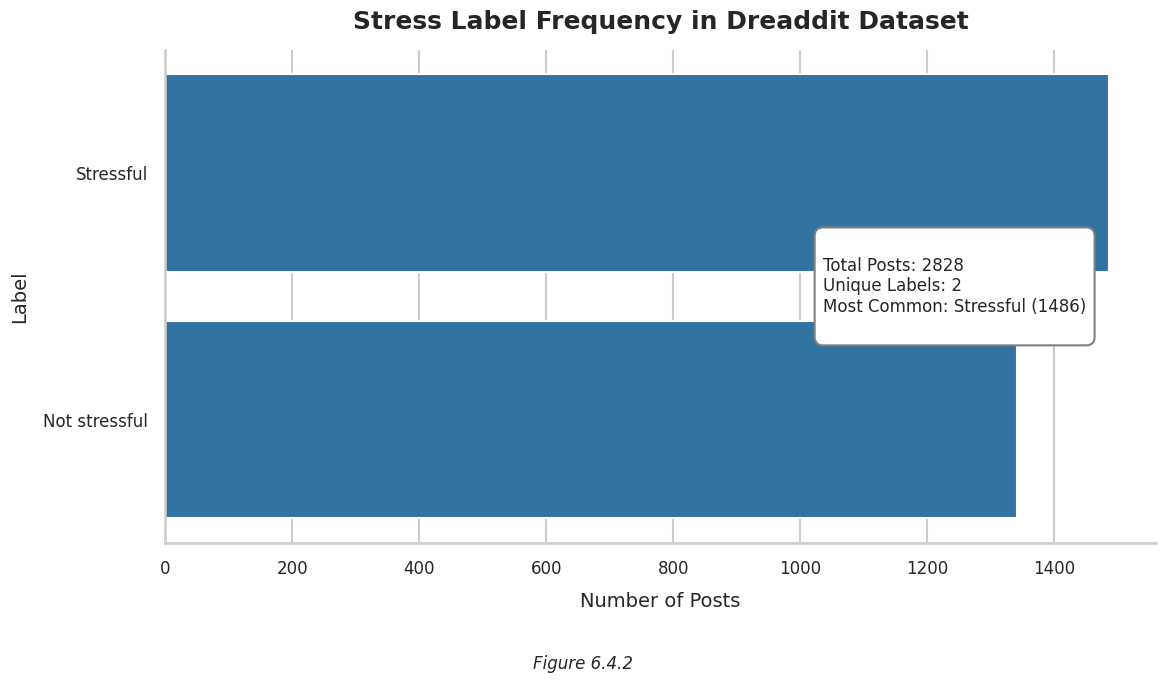

In [66]:
# Calculate label counts for summary stats
label_counts = dreaddit['label'].value_counts()

# Basic statistics
total_labels = len(dreaddit)
num_classes = dreaddit['label'].nunique()
most_common_label = label_counts.idxmax()
most_common_count = label_counts.max()

# Create figure and axis for better layout control
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the frequency of labels
sns.countplot(
    data=dreaddit,
    y='label',
    order=label_counts.index,
    ax=ax
)

# Add title and axis labels
ax.set_title('Stress Label Frequency in Dreaddit Dataset', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Number of Posts', fontsize=14, labelpad=10)
ax.set_ylabel('Label', fontsize=14, labelpad=10)

# Adjust tick label sizes for readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Remove spines for a cleaner appearance
sns.despine(ax=ax)

# Add summary stats box inside the figure
fig.text(
    0.7, 0.5,
    f'''
Total Posts: {total_labels}
Unique Labels: {num_classes}
Most Common: {most_common_label} ({most_common_count})
''',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
)

# Adjust layout and leave space at the bottom for a caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure caption below the plot
fig.text(
    0.5, 0.02,
    'Figure 6.4.2',
    fontsize=12,
    fontstyle='italic',
    ha='center'
)

plt.show()

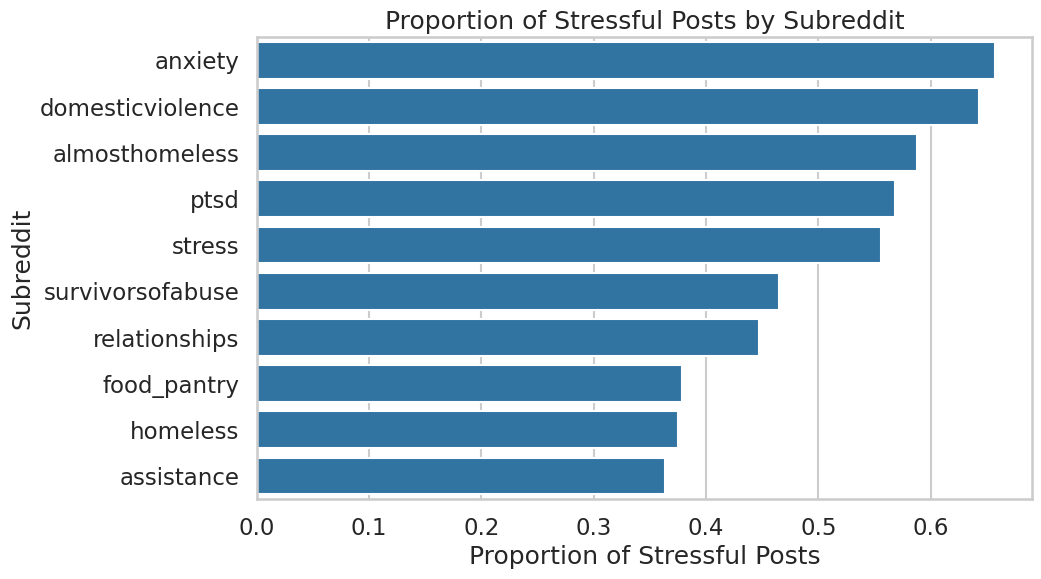

In [67]:
# Calculate proportion of stressful posts per subreddit
subreddit_stress = (
    dreaddit.groupby('subreddit')['label_num']
    .mean()
    .sort_values(ascending=False)
)

# Plot proportion of stressful posts by subreddit
plt.figure(figsize=(10, 6))
sns.barplot(x=subreddit_stress.values, y=subreddit_stress.index)
plt.title('Proportion of Stressful Posts by Subreddit')
plt.xlabel('Proportion of Stressful Posts')
plt.ylabel('Subreddit')
plt.show()

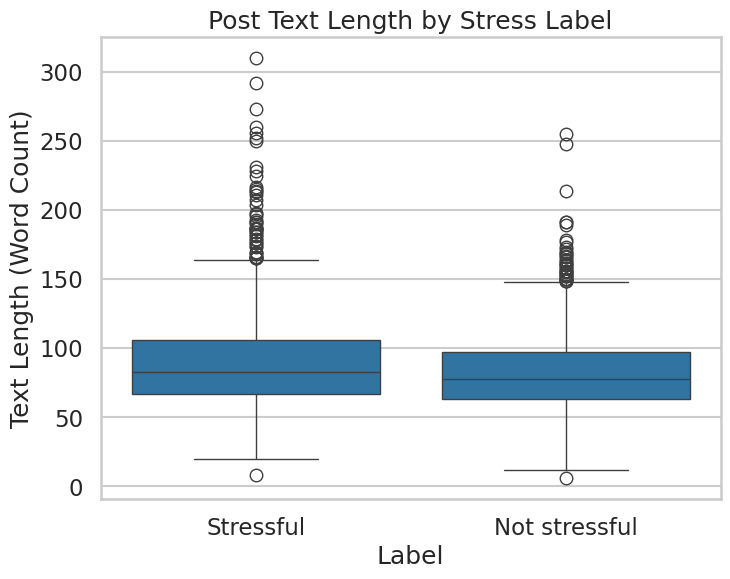

In [68]:
# Plot post text length by stress label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='text_length', data=dreaddit)
plt.title('Post Text Length by Stress Label')
plt.xlabel('Label')
plt.ylabel('Text Length (Word Count)')
plt.show()

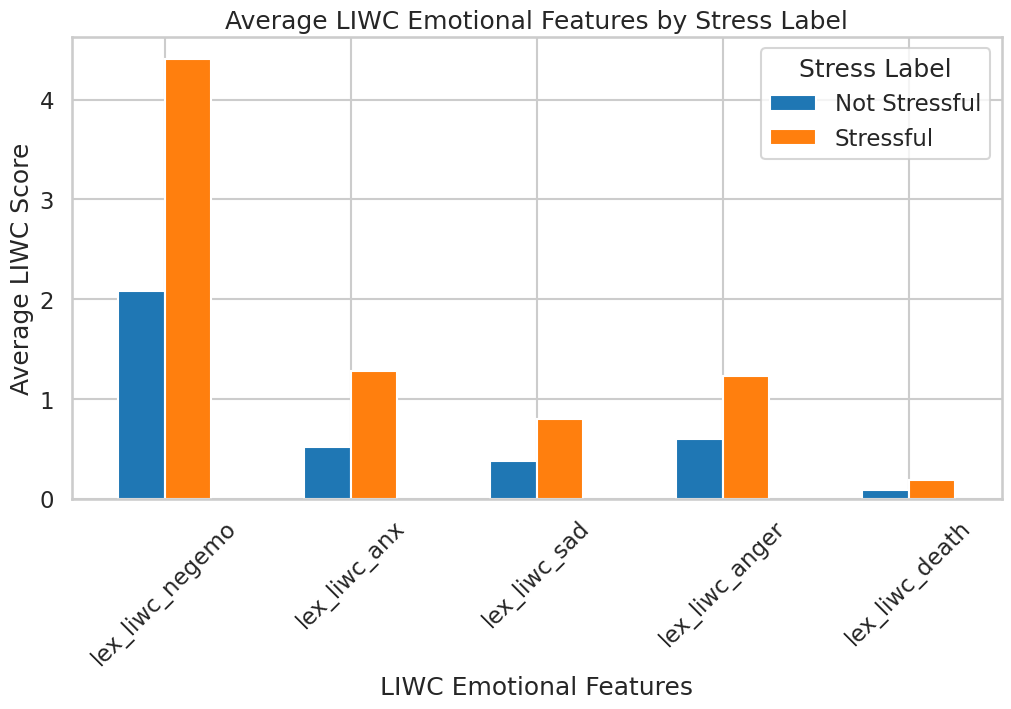

In [69]:
# Compare LIWC emotional features across stress labels
liwc_emotion_cols = [
    'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_sad',
    'lex_liwc_anger', 'lex_liwc_death'
]

(
    dreaddit[liwc_emotion_cols + ['label_num']]
    .groupby('label_num')
    .mean()
    .T
    .plot(kind='bar', figsize=(12, 6))
)
plt.title('Average LIWC Emotional Features by Stress Label')
plt.ylabel('Average LIWC Score')
plt.xlabel('LIWC Emotional Features')
plt.legend(title='Stress Label', labels=['Not Stressful', 'Stressful'])
plt.xticks(rotation=45)
plt.show()

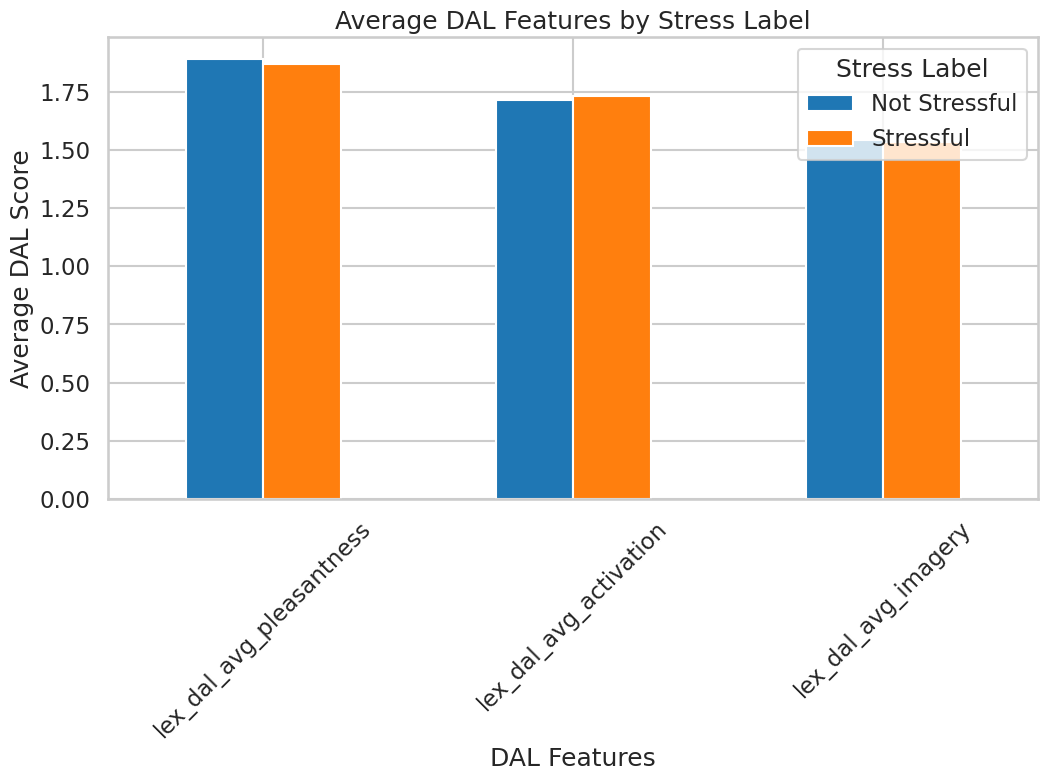

In [70]:
# Compare DAL features across stress labels
dal_cols = [
    'lex_dal_avg_pleasantness',
    'lex_dal_avg_activation',
    'lex_dal_avg_imagery'
]

(
    dreaddit[dal_cols + ['label_num']]
    .groupby('label_num')
    .mean()
    .T
    .plot(kind='bar', figsize=(12, 6))
)

plt.title('Average DAL Features by Stress Label')
plt.ylabel('Average DAL Score')
plt.xlabel('DAL Features')
plt.legend(title='Stress Label', labels=['Not Stressful', 'Stressful'])
plt.xticks(rotation=45)
plt.show()

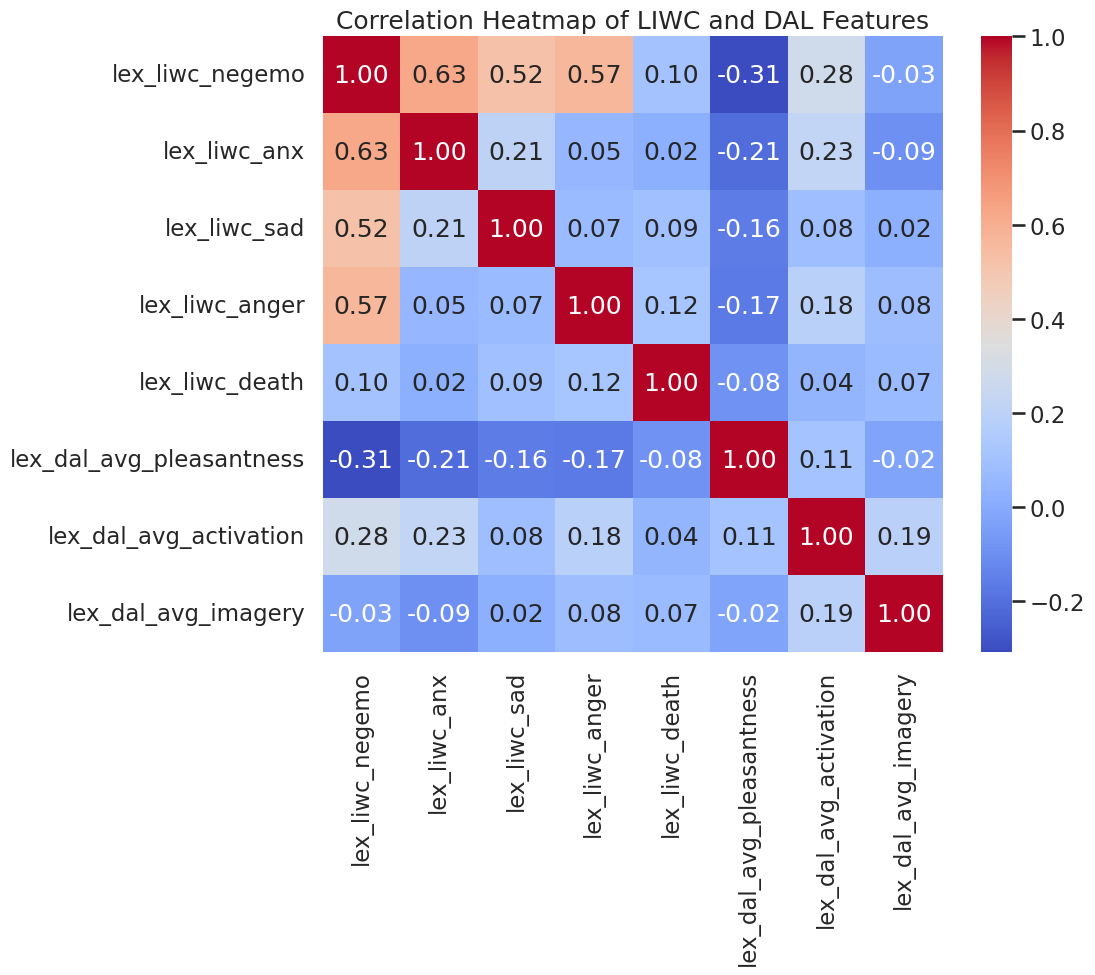

In [71]:
# Correlation matrix for psycholinguistic features (LIWC and DAL)
psycholinguistic_cols = liwc_emotion_cols + dal_cols
correlation_matrix = dreaddit[psycholinguistic_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of LIWC and DAL Features')
plt.show()